# Create .mp4 movies from frames

In order to calibrate our pupil labs system to the world cam we actually WANT to use (ximea cameras) we need to do offline calibration. To do that, we need both an .mp4 for pupil labs to read, as well as a set of timestamps for each frame of the mp4 file. Here we generate both these.  


## Dependencies

In [1]:
import os, stat
import numpy as np
import cv2
import imageio
import utils.run_analysis as ana

## Parameters

In [2]:
subject = 'buddy'
trial = 'cellphone_1'
camera = 'cy'
base_dir = '/data_repo/bravo'
output_dir = os.path.join(base_dir, 'analysis')
analysis_folder = os.path.join(output_dir, subject, trial, camera)
img_dims=(1544,2064)

#for next data
pngs_dir = os.path.join(analysis_folder,'pngs')
#pngs_dir = os.path.join(analysis_folder, camera, 'pngs')

## Specify Directories

In [3]:
data_dir = os.path.join(base_dir, 'raw_data')
trial_directory = os.path.join(data_dir, subject, trial, 'pre')
ximea_timestamp_file = os.path.join(trial_directory, 'scene_camera', f'timestamps_{camera}.tsv')
ximea_timesync_file = os.path.join(trial_directory, 'scene_camera', f'timestamp_camsync_{camera}.tsv')


In [4]:
analysis_folder

'/data_repo/bravo/analysis/buddy/cellphone_1/cy'

## Write Timestamps
We already have timestamps, but we need them to be in the format tha pupil labs expects from a world cam.

In [5]:
#a = np.load(os.path.join(trial_directory,'eye_camera','000','world_timestamps.npy'))
world_timestamps = ana.convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)[:,3]
np.save(os.path.join(analysis_folder, 'world_timestamps.npy'),world_timestamps) 

Time Elapsed: 60.93483090400696 seconds
Time Drift pre to post: 0.002594831993008029 seconds
Start at 1575571087.1113873, end at 1575571146.2747233


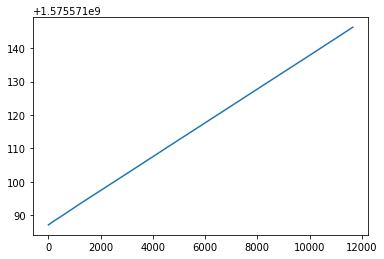

In [6]:
import matplotlib.pyplot as plt
plt.plot(world_timestamps)

## Write Video

In [7]:
number_frames = len([name for name in os.listdir(pngs_dir) if os.path.isfile(os.path.join(pngs_dir,name))])
print(number_frames)

12200


In [ ]:
video_filename = os.path.join(analysis_folder, 'world.mp4')
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
video = cv2.VideoWriter(video_filename, fourcc, 200, img_dims[::-1], 1)

for i in range(number_frames):
    frame = imageio.imread(os.path.join(analysis_folder,'pngs',f'frame_{i}.png'))
    frame = frame/np.max(frame)
    video.write(cv2.cvtColor(np.uint8(frame*255), cv2.COLOR_BGR2RGB))
video.release()
print('Done!')

## Function to Loop Through Timestamp convert

In [9]:
def write_ximea_timestamps(trial_directory, analysis_folder, camera):
                           
    ximea_timestamp_file = os.path.join(trial_directory, 'scene_camera', f'timestamps_{camera}.tsv')
    ximea_timesync_file = os.path.join(trial_directory, 'scene_camera', f'timestamp_camsync_{camera}.tsv')

    world_timestamps = ana.convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)[:,3]
    np.save(os.path.join(analysis_folder, camera,'world_timestamps.npy'),world_timestamps)
    

In [13]:
import itertools as it
base_dir = '/data_repo/bravo'
subjects = ['jf']
tasks = ['cell_phone', 'laptop']
repititions = ['1','2','3']
cameras = ['cy']
iterator = it.product(subjects, tasks, repititions, cameras)

for iteration in iterator:
    subject, task, rep, camera = iteration
    output_dir = os.path.join(base_dir, 'analysis')
    analysis_folder = os.path.join(output_dir, subject, trial)
    trial = f'{task}_{rep}'
    if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
        trial_directory = os.path.join(base_dir, 'raw_data', subject, trial, 'pre')
        analysis_folder = os.path.join(base_dir, 'analysis', subject, trial)
        write_ximea_timestamps(trial_directory, analysis_folder, camera)

Time Elapsed: 135.3787317276001 seconds
Time Drift pre to post: 0.018285096399949907 seconds
1574810720.7608986
Time Elapsed: 135.2961688041687 seconds
Time Drift pre to post: 0.018304411831309153 seconds
1574810921.4236894
Time Elapsed: 136.0369143486023 seconds
Time Drift pre to post: 0.015845579397705478 seconds
1574811110.9803076
Time Elapsed: 136.31205368041992 seconds
Time Drift pre to post: 0.015955095580238776 seconds
1574811439.918789
Time Elapsed: 136.78098344802856 seconds
Time Drift pre to post: 0.018499615971450112 seconds
1574811588.4511204


## Function to Loop Through mp4 convert

In [16]:
def convert_pngs_mp4(analysis_folder, camera, img_dims):
    '''
    Convert a set of pngs to mp4 movie (for purposes of spatial calibration for ximea and pupil labs)
    
    '''
    
    pngs_dir = os.path.join(analysis_folder,camera, 'pngs')
    #pngs_dir = os.path.join(analysis_folder,'pngs',camera)
    number_frames = len([name for name in os.listdir(pngs_dir) if os.path.isfile(os.path.join(pngs_dir,name))])
    print(f'Converting {number_frames} frames to .mp4')
    
    video_filename = os.path.join(analysis_folder, f'world_{camera}.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'FMP4')
    video = cv2.VideoWriter(video_filename, fourcc, 200, img_dims[::-1], 1)
    for i in range(number_frames):
        frame = np.flipud(np.fliplr(imageio.imread(os.path.join(pngs_dir,f'frame_{i}.png'))))
        frame = frame/np.max(frame)
        video.write(cv2.cvtColor(np.uint8(frame*255), cv2.COLOR_BGR2RGB))
    video.release()

In [18]:
import itertools as it
subjects = ['ag']
tasks = ['chat', 'book','cell_phone', 'laptop']
repititions = ['1']
cameras = ['cy']
iterator = it.product(subjects, tasks, repititions, cameras)
img_dims=(1544,2064)


for iteration in iterator:
    subject, task, rep, camera = iteration
    trial = f'{task}_{rep}'
    if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
        trial_directory = os.path.join(base_dir, 'raw_data', subject, trial, 'pre')
        analysis_folder = os.path.join(base_dir, 'analysis', subject, trial)
        convert_pngs_mp4(analysis_folder, camera, img_dims)


/data_repo/bravo/analysis/jf/cell_phone_2 cy (1544, 2064)
Converting 0 frames to .mp4
/data_repo/bravo/analysis/jf/cell_phone_3 cy (1544, 2064)
Converting 0 frames to .mp4
/data_repo/bravo/analysis/jf/laptop_2 cy (1544, 2064)
Converting 0 frames to .mp4


## In Pupil Player

On a computer with pupil player:
1. replace the old world.mp4 and world_timestamps.npy files with those generated here. 
2. Open the folder in pupil player and click the calibration button (target icon). Choose 'Gaze from Offline Calibration', then click 'Calculate All Calibrations and Mappings' This may take awhile, especcially the calibrations substep.
3. Click the 'Raw Data Exporter' button to export the new calibration data. This may also take awhile
4. Upload this exported data to back to the server for analysis, into  the appropriate 'analysis_folder'